# Setting up the Environment

To install the dependencies needed to run this notebook, run the following cell under the condition that this notebook is located in the same directory as `requirements.txt`.

In [63]:
# pip install -r requirements.txt

In [1]:
import os

os.environ['XDG_CACHE_HOME'] = '/home/msds2023/jwong/.cache'
os.environ['HUGGINGFACE_HUB_CACHE'] = '/home/msds2023/jwong/.cache'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import datasets
from datasets import Dataset, DatasetDict

import evaluate

import transformers
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification
)
from transformers import get_scheduler

2023-06-13 17:50:01.254794: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Navigating the Programming Maze: <br> Predicting Stack Overflow Question Quality with Deep Learning

## Introduction: Why Stack Overflow Matters to Users

If you've dabbled in coding, chances are you're familiar with Stack Overflow—the ultimate savior for programmers facing countless challenges. Stack Overflow, a thriving question and answer website, serves as an invaluable hub for collaboration and knowledge exchange among developers. Here, programmers can pose questions spanning various programming languages, frameworks, and technologies, seeking guidance and solutions for their coding dilemmas. A diverse community of experts and enthusiasts promptly responds, offering insights, expertise, and engaging in constructive discussions that shape the platform's vibrant ecosystem.



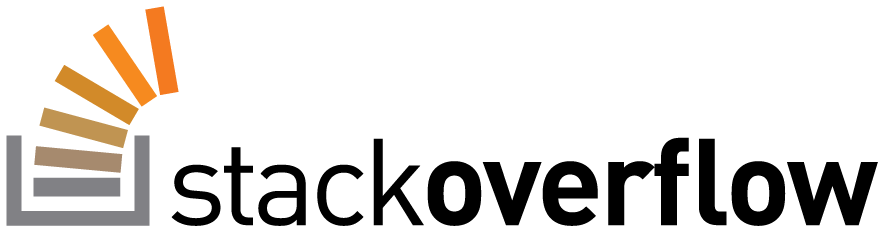

In today's information-rich era, Stack Overflow has become the primary destination for developers seeking answers to their programming questions. With an extensive collection of millions of questions and corresponding answers, the quality of these inquiries plays a pivotal role in fostering a vibrant and effective community. In this blog, we delve into the problem of predicting Stack Overflow question quality. By identifying which questions are more likely to garner community engagement and productivity, we aim to enhance the overall experience of users and facilitate efficient knowledge sharing.

## Motivation: Enhancing User Experience and Efficiency

Stack Overflow serves as a valuable resource for programmers, offering a wealth of knowledge. However, the process of sifting through numerous questions to find high-quality and relevant information can be arduous and frustrating. When navigating the Stack Overflow platform, users often encounter various obstacles. The sheer volume of questions can be overwhelming, with millions of inquiries vying for attention. This information overload makes it challenging to locate answers swiftly and effectively. Additionally, not all questions are created equal. Users frequently stumble upon poorly structured, ambiguous, or duplicate questions that clutter the platform. Such low-quality questions impede productivity and may lead to misleading or insufficient answers. As users attempt to find accurate and valuable information, they must wade through this sea of subpar queries, diverting them from their primary objective. This challenge highlights the need for a solution that can enhance the user experience and efficiency on Stack Overflow.

I'm sure you're familiar with ChatGPT and you may ask, why even bother with Stack Overflow anymore? While traffic to OpenAI’s ChatGPT has been growing exponentially, Stack Overflow has been experiencing a steady decline, losing some of its standings as the go-to source developers turn to for answers to coding challenges. In fact, traffic to Stack Overflow (stackoverflow.com) was down by 13.9% in March 2023 after the release of ChatGPT [1].

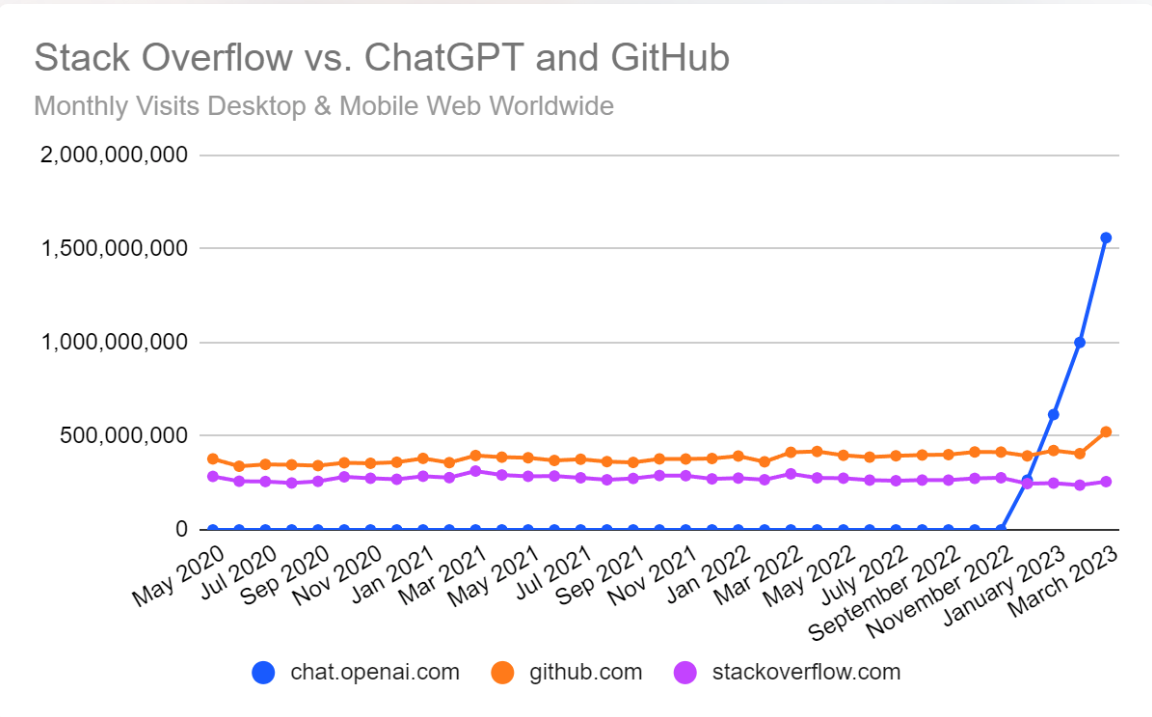

<p style="text-align: center"><b>Figure 1.</b> Monthly Visits to Desktop and Mobile Web from May 2020 to March 2023 for OpenAI, Github, and Stack Overflow</p>

However, there are compelling reasons to keep using Stack Overflow. Stack Overflow offers specialized domain expertise in programming, with its own ecosystem of guidelines, norms, and quality standards. The collaborative nature of the platform taps into the collective intelligence of users, surpassing the breadth and depth of knowledge that ChatGPT can provide. Maintaining quality content is paramount to Stack Overflow's success, and predicting question quality aids in identifying and managing low-quality or irrelevant content. Unlike ChatGPT, Stack Overflow remains up-to-date with the latest engagements, ensuring ongoing usefulness and relevance to developers. Moreover, Stack Overflow's level of curation and adherence to community quality standards sets it apart from ChatGPT, making it an indispensable resource for programming challenges. By enabling users to quickly find relevant and well-structured questions, Stack Overflow can continue to offer a distinct advantage over ChatGPT in the context of programming knowledge and expertise. This improvement ensures that Stack Overflow remains a valuable and indispensable resource for developers.

Predicting question quality using NLP techniques and deep learning addresses pain points on Stack Overflow. This approach brings several benefits to users. Firstly, it improves search results and recommendations by prioritizing higher-quality questions, enabling users to find relevant and well-structured queries more quickly. Secondly, it filters out low-quality or redundant questions, reducing noise and allowing users to focus on questions with a higher chance of providing meaningful answers, saving time and enhancing efficiency.

## Background on NLP and DL

Recent advancements in Natural Language Processing and Deep Learning have revolutionized the analysis of textual data. One significant advancement in the field is the rise of transformer models. Transformers have proven to be highly effective in tasks such as machine translation, text summarization, and sentiment analysis. In particular, attention mechanisms, inherent in transformer models, play a crucial role in identifying key features and context. This makes them ideal for understanding the intricate nuances of natural language. Below is the original transformer architecture introduced by introduced by Vaswani et al. in 2017 [2].

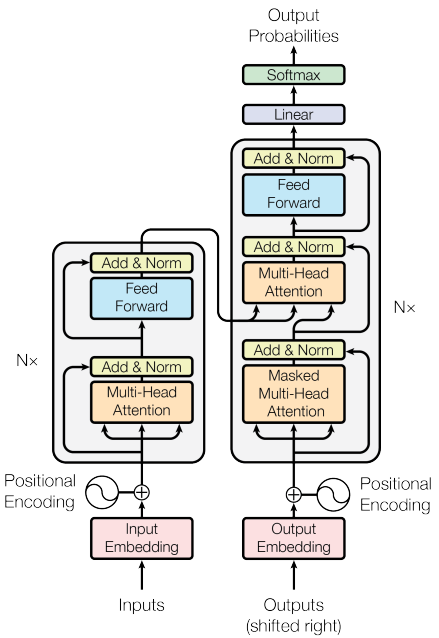

<p style="text-align: center"><b>Figure 2.</b> Original Transformer Architecture</p>

The emergence of Transfer Learning has transformed the way we leverage Pre-trained Models (PTM) in the field of deep learning. Transfer Learning allows us to take advantage of the vast knowledge encoded within PTMs and adapt them to our specific tasks and domains. In the context of our project focused on Stack Overflow questions, we can fine-tune a PTM on a large corpus of Stack Overflow data. This process involves adjusting the model's parameters to better understand the nuances and characteristics specific to Stack Overflow questions. We will be implementing this in the next sections below.

## The Dataset

**60k Stack Overflow Questions with Quality Rating**

This dataset from [Kaggle](https://www.kaggle.com/datasets/imoore/60k-stack-overflow-questions-with-quality-rate) is a comprehensive collection of 60,000 questions sourced from Stack Overflow, spanning the years 2016 to 2020. These questions have been carefully classified into three distinct categories based on their quality [3].

1. `HQ`: High-quality posts without a single edit. [Example](https://stackoverflow.com/questions/60422693/weird-indexing-using-numpy).
1. `LQ_EDIT`: Low-quality posts with a negative score, and multiple community edits. However, they still remain open after those changes. [Example](https://stackoverflow.com/questions/60454978/input-data-is-not-loading-into-database).
1. `LQ_CLOSE`: Low-quality posts that were closed by the community without a single edit. [Example](https://stackoverflow.com/questions/60468018/how-can-i-make-a-c-sharp-application-outside-of-visual-studio).

| Feature       | Data Type        | Description                                |
|---------------|------------------|--------------------------------------------|
| Id            | int64            | Unique identifier for each question         |
| Title         | string           | Title of the question                       |
| Body          | string           | Body or content of the question             |
| Tags          | string           | Tags or categories associated with the question |
| CreationDate  | datetime64[ns]   | Date and time when the question was created |
| Y             | string           | Quality rating or classification label of the question |
<p style="text-align: center"><b>Table 1.</b> Data Description of the Stack Overflow Dataset</p>

Below are screenshots of examples of each quality type of post.

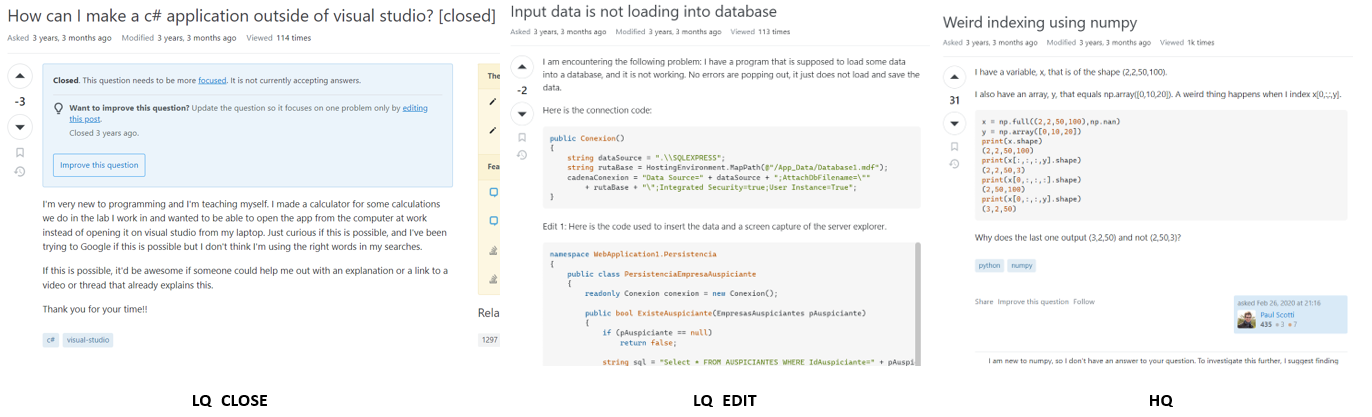

<p style="text-align: center"><b>Figure 3.</b> Sample Low Quality-Closed (left), Low Quality-Edited (center), High Quality (right) Stack Overflow Questions</p>

## Methodology

### Data Loading

In [3]:
df = pd.concat(
    [pd.read_csv('data/train.csv'), pd.read_csv('data/valid.csv')]
).reset_index(drop=True)

df['CreationDate'] = pd.to_datetime(df['CreationDate'])

### Exploratory Data Analysis

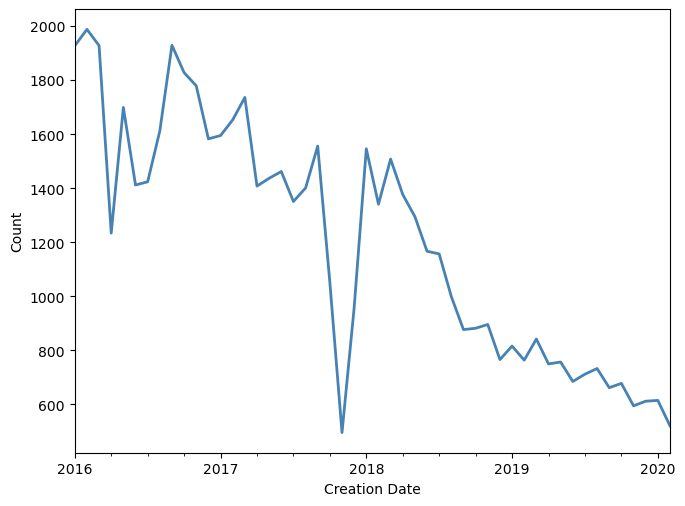

In [4]:
plt.figure(figsize=(6.4*1.2, 4.8*1.2))
df.set_index('CreationDate').resample('M')['Y'].count().plot(
    color='steelblue',
    lw=2
)
plt.xlabel('Creation Date')
plt.ylabel('Count')
plt.show()

<p style="text-align: center"><b>Figure 5.</b> Number of Questions Posted in Stack Overflow through Time</p>

There is a noticeable drop in the number of questions as time flows forward. This can be attributed to the fact that answered questions will always be in the platform and beginner programmers are more likely to encounter problems which have already been answered, hence negating the need to post new questions.

In [5]:
tag_freq = df.Tags.str.extractall(r'<([+\w#.-]*)>')[0].value_counts()

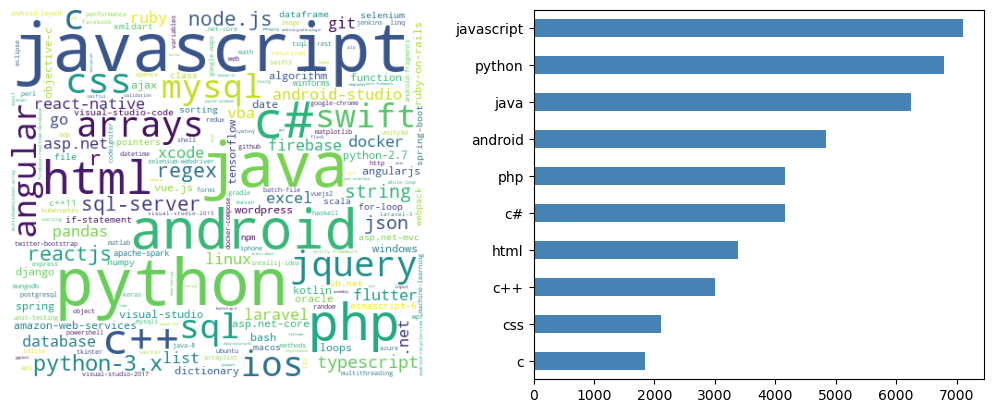

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))

wc = WordCloud(width=450, height=400, background_color='white')
ax[0].imshow(wc.generate_from_frequencies(tag_freq))
ax[0].axis('off')
tag_freq.iloc[:10].sort_values().plot.barh(ax=ax[1], color='steelblue')
plt.show()

<p style="text-align: center"><b>Figure 6.</b> Top Tags in the Dataset</p>

Most questions in the dataset fall under topics in Java, Python, Android, PHP, and C#.

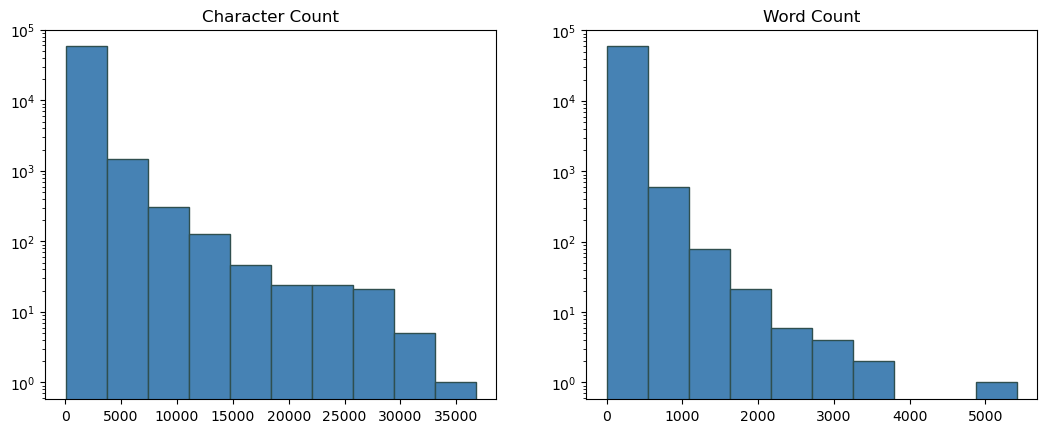

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))
df['Body'].apply(lambda x: len(x)).hist(color='steelblue',
                                        ec='darkslategray', ax=ax[0])
ax[0].set_title('Character Count')
ax[0].set_yscale('log')
ax[0].grid(False)

df['Body'].apply(lambda x: len(x.split())).hist(color='steelblue',
                                                ec='darkslategray', ax=ax[1])
ax[1].set_title('Word Count')
ax[1].set_yscale('log')
ax[1].grid(False)

plt.show()

<p style="text-align: center"><b>Figure 7.</b> Distribution of Character Counts and Word Counts in the Data</p>

Note that this distribution is in logarithmic scale, implying that the actual distribution is much more flat to the right. This means that most question bodies tend to be short, which is expected as you typically just give context to the problem when you write something in the body of the question.

### Preprocessing

Since our aim is to use the textual features to predict quality, we preprocess the text data to make it parseable by the PTM that we will use later. First, we label-encode the target variables. To further clean the text data, we remove punctations and other special characters. Lastly we convert the entire text to lower case.

In [127]:
df['text'] = df['Title'] + ' ' + df['Body']

In [128]:
qual_dict = {'LQ_CLOSE': 0, 'LQ_EDIT': 1, 'HQ': 2}

df['target'] = df['Y'].map(qual_dict)

In [129]:
df['text'] = df['text'].str.replace(
    '<(.|\n)*?>', ' ', regex=True
)
df['text'] = df['Body'].str.replace(
    '[^(a-zA-Z)\s]', '', regex=True
)
df['text'] = df['text'].str.lower()

In [130]:
df_train, df_valid = (
    df[['text', 'target']].iloc[:45_000],
    df[['text', 'target']].iloc[45_000:]
)

### Modeling

#### Loading the PTM

For our implementation, we will be using a BERT. Bidirectional Encoder Representations from Transformers (BERT), is a state-of-the-art language model developed by Google which revolutionized the field of Natural Language Processing (NLP) by utilizing a transformer-based architecture that trains on both left and right contexts of an input sequence, allowing it to capture deep contextual relationships in language [4]. This model was pre-trained with two objectives: masked language modeling and next sentence prediction. Further details can be found in [5].

In particular, we will be using the [`bert-base-uncased`](https://huggingface.co/bert-base-uncased) model which we can load directly from Hugging Face.

In [3]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', num_labels=3)
model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=3
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [133]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

#### Tokenization

In the tokenization phase, the input data is processed into a format suitable for deep learning models. The text is divided into individual tokens, which can be words, subwords, or characters, depending on the chosen tokenization strategy. This process is a crucial step as it enables the conversion of raw text into numerical representations that can be fed into the model for training and evaluation. This step is accounted for by the `tokenizer` we previously loaded from `AutoTokenizer`.

In [134]:
def tokenize_function(examples):
    """
    Callable function for tokenizer.
    """
    global tokenizer
    return tokenizer(examples["text"], padding="max_length",
                     return_tensors='pt', truncation=True)

In [135]:
datasets_train_test = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "test": Dataset.from_pandas(df_valid)
    })

In [136]:
tokenized_datasets = datasets_train_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/45000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

In [137]:
tokenized_datasets = tokenized_datasets.remove_columns(['text'])
tokenized_datasets = tokenized_datasets.rename_column("target", "labels")
tokenized_datasets.set_format("torch")

train_dataloader = DataLoader(tokenized_datasets["train"],
                              shuffle=True,
                              batch_size=8)
valid_dataloader = DataLoader(tokenized_datasets["test"],
                              batch_size=8)

#### Training

During the training phase, the preprocessed data is used to train the deep learning model. This involves feeding the tokenized input data along with their corresponding labels into the model and optimizing its parameters based on a loss function. In particular, we chose `AdamW` as our optimizer and use the loss defined by our BERT PTM. The model learns to capture patterns and relationships in the data through iterative updates, using techniques such as backpropagation and gradient descent. The training process continues for multiple steps, gradually refining the model's ability to perform the task at hand.

In [138]:
optimizer = optim.AdamW(model.parameters() , lr=5e-5)

num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name='linear',
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [139]:
progress_bar = tqdm(range(num_training_steps))

model.train()
counter = 0
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        
        if counter%500 == 0:
            print('='*40)
            print(f'Step {counter:4d} || Train Loss = {loss:.4f}')
            print('='*40)

        loss.backward()
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        counter += 1

  0%|          | 0/5625 [00:00<?, ?it/s]

Step    0 || Train Loss = 1.2613
Step  500 || Train Loss = 0.5590
Step 1000 || Train Loss = 0.5505
Step 1500 || Train Loss = 0.2642
Step 2000 || Train Loss = 0.3775
Step 2500 || Train Loss = 0.4027
Step 3000 || Train Loss = 0.0103
Step 3500 || Train Loss = 0.0159
Step 4000 || Train Loss = 0.1005
Step 4500 || Train Loss = 0.0496
Step 5000 || Train Loss = 0.2277
Step 5500 || Train Loss = 0.1428


In [125]:
# model.save_pretrained('models/bert-tuned-with-title/')
# model.save_pretrained('models/bert-tuned-no-title/')
# model.save_pretrained('models/bert-tuned-no-title-keep-punc/')

#### Evaluation

After training, the model is evaluated to assess its performance and generalization capabilities. The evaluation phase involves applying the trained model to a separate test dataset that was not used during training. The model's predictions are compared against the ground truth labels to calculate various evaluation metrics. These metrics provide insights into the model's ability to classify questions correctly and identify areas where further improvements may be needed.

In [140]:
metric = evaluate.load("accuracy")
model.eval()

all_true = []
all_preds = []
for batch in tqdm(valid_dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])
    
    all_true.append(batch['labels'])
    all_preds.append(predictions)

  0%|          | 0/1875 [00:00<?, ?it/s]

In [141]:
metric.compute()

{'accuracy': 0.9118666666666667}

## Results and Discussion

The model was able to classify unseen data with **91.18%** accuracy. Below we show a confusion matrix as well as classification report to interpret the results.

In [145]:
y_test = torch.cat(all_true).cpu().detach().numpy()
y_pred = torch.cat(all_preds).cpu().detach().numpy()

In [146]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      5000
           1       1.00      1.00      1.00      5000
           2       0.89      0.84      0.87      5000

    accuracy                           0.91     15000
   macro avg       0.91      0.91      0.91     15000
weighted avg       0.91      0.91      0.91     15000



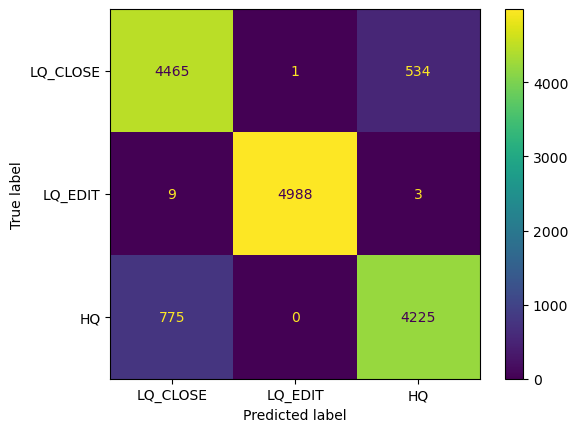

In [147]:
classes = ['LQ_CLOSE', 'LQ_EDIT', 'HQ']
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)

disp.plot(cmap='viridis')
plt.show()

<p style="text-align: center"><b>Figure 8.</b> Confusion Matrix of the Validation Set Predictions</p>

The results of our classification model reveal interesting insights regarding the classification of low-quality questions with multiple edits (`LQ_EDIT`) on Stack Overflow. Upon analyzing the classification report and confusion matrix, it becomes apparent that our model demonstrates a higher accuracy and precision in classifying the LQ_EDIT category compared to other low-quality classes.

The high precision achieved in the LQ_EDIT category indicates that our model is proficient in identifying and categorizing questions that have undergone multiple community edits while still remaining open. This suggests that the content within these questions, despite their initial low-quality state, undergoes improvements through community involvement. By correctly identifying these questions, our model can provide valuable insights and support to users seeking assistance on Stack Overflow.

The improved performance in classifying LQ_EDIT questions may be attributed to the specific characteristics of this class. These questions, although initially low-quality, have benefited from the collective knowledge and contributions of the Stack Overflow community. As a result, they exhibit certain linguistic or contextual cues that enable our model to differentiate them from other low-quality questions.

Furthermore, the model's ability to classify LQ_EDIT questions effectively indicates that Stack Overflow's collaborative nature and community-driven edits play a significant role in improving question quality over time. This finding emphasizes the importance of community participation and engagement in enhancing the overall quality of questions on the platform.

## Conclusion and Recommendation

In conclusion, utilizing the BERT model for predicting Stack Overflow question quality resulted in a test accuracy of 91.18%. The results of our analysis indicate that the model exhibits a higher precision in classifying `LQ_EDIT`. This approach demonstrates the effectiveness of leveraging advanced natural language processing techniques for assessing the quality of questions on the platform. The achieved accuracy highlights the potential of using BERT as a valuable tool for improving the user experience and efficiency in finding high-quality answers on Stack Overflow. 

Moreover, incorporating deep learning explainability methods can provide valuable insights into the model's decision-making process. Techniques such as attention visualization and feature analysis can help identify the most influential linguistic aspects in the classification process, guiding further feature engineering efforts and improving the transparency of the model's predictions. An exciting extension of this work involves incorporating a paraphrasing model after the classification model to improve low-quality questions. However, it is important to first address the lack of high-quality paraphrase dataset by gathering additional training data or exploring data augmentation techniques.

Implementing these recommendations can lead to significant advancements in accurately classifying low-quality questions, reducing biases, improving feature selection, increasing explainability, and ultimately elevating the overall quality of questions on Stack Overflow. By continuously refining and enhancing the model, we can contribute to the improvement of the Stack Overflow community and provide a more valuable resource for developers seeking high-quality answers to their programming queries.

## References

[1] Carr D. (2023, April 19). Stack Overflow is ChatGPT Casualty: Traffic Down 14% in March. Retrieved from [URL](https://www.similarweb.com/blog/insights/ai-news/stack-overflow-chatgpt/).

[2] Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. Advances in neural information processing systems, 30. [URL](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf).

[3] Annamoradnejad, I., Habibi, J., & Fazli, M. (2022). Multi-view approach to suggest moderation actions in community question answering sites. Information Sciences, 600, 144-154. [URL](https://www.sciencedirect.com/science/article/abs/pii/S0020025522003127).

[4] Kenton, J. D. M. W. C., & Toutanova, L. K. (2019, June). Bert: Pre-training of deep bidirectional transformers for language understanding. In Proceedings of naacL-HLT (Vol. 1, p. 2). [URL](https://aclanthology.org/N19-1423.pdf).

[5] Horev R. (2018, November 11). BERT Explained: State of the art language model for NLP \[Blog post\]. Retrieved from [URL](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270).